# MASt3R Raw Output Visualization

This notebook demonstrates how to:
1. Load and run MASt3R inference on two images
2. Visualize raw geometric and feature-based outputs
3. Export raw data for further analysis

## Outputs Visualized:
- **Input Images**: Original RGB pair
- **Depth Maps**: Extracted from pointmaps (z-channel)
- **Confidence Maps**: Network's certainty for each pixel
- **Feature Descriptors (PCA)**: High-dimensional descriptors reduced to 3 components and visualized as RGB


## 1. Environment Setup

First, we need to install MASt3R and its dependencies. Run this cell to install the required packages.


In [1]:
# Install MASt3R and dependencies
# Note: This assumes you're in the mast3r repository root
# If running from a different location, adjust the paths accordingly

import sys
import os

# Get the current working directory (should be the mast3r repo root)
repo_root = os.getcwd()
print(f"Repository root: {repo_root}")

# Add repository root to Python path
# This allows imports like: from mast3r.model import ...
# and: from dust3r.dust3r.inference import ...
if repo_root not in sys.path:
    sys.path.insert(0, repo_root)
    print(f"✓ Added repository root to Python path")

# Verify we can find the necessary directories
mast3r_dir = os.path.join(repo_root, 'mast3r')
dust3r_dir = os.path.join(repo_root, 'dust3r')
if os.path.exists(mast3r_dir):
    print(f"✓ Found mast3r directory")
if os.path.exists(dust3r_dir):
    print(f"✓ Found dust3r directory")

# Check if packages are available, if not provide installation instructions
try:
    import torch
    import numpy as np
    import matplotlib.pyplot as plt
    from sklearn.decomposition import PCA
    from PIL import Image
    print("\n✓ Core packages available")
except ImportError as e:
    print(f"\n✗ Missing package: {e}")
    print("\nPlease install required packages:")
    print("  pip install torch torchvision numpy matplotlib scikit-learn pillow")
    print("  pip install -r requirements.txt")
    print("  pip install -r dust3r/requirements.txt")

# Test if MASt3R modules can be imported (this will help catch path issues early)
print("\nTesting MASt3R imports...")
try:
    import mast3r.utils.path_to_dust3r  # noqa - this sets up dust3r paths
    print("✓ mast3r.utils.path_to_dust3r imported")
    
    # Try importing from dust3r to verify path setup
    # NOTE: After path_to_dust3r, imports are 'from dust3r.inference' not 'dust3r.dust3r.inference'
    from dust3r.inference import inference  # noqa
    print("✓ dust3r.inference imports working")
except ImportError as e:
    print(f"⚠ Warning: Could not import MASt3R modules: {e}")
    print("  This might be okay if you haven't installed MASt3R yet.")
    print("  Make sure you're running this notebook from the mast3r repository root.")


Repository root: /home/yashturkar/Workspace/mast3r
✓ Added repository root to Python path
✓ Found mast3r directory
✓ Found dust3r directory

✓ Core packages available

Testing MASt3R imports...
✓ mast3r.utils.path_to_dust3r imported
✓ dust3r.inference imports working


## 2. Import Libraries and Setup


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from PIL import Image
import os
import sys

# CRITICAL: Import path_to_dust3r FIRST to set up the dust3r module path
# This must be done before any dust3r imports
import mast3r.utils.path_to_dust3r  # noqa - this sets up dust3r paths
print("✓ dust3r path configured via mast3r.utils.path_to_dust3r")

# Now import MASt3R modules
# NOTE: After path_to_dust3r, 'dust3r' refers to dust3r/dust3r/, so imports are:
# from dust3r.inference (NOT dust3r.dust3r.inference)
from mast3r.model import AsymmetricMASt3R
from dust3r.inference import inference
from dust3r.image_pairs import make_pairs
from dust3r.utils.image import load_images
from dust3r.utils.device import to_numpy

print("✓ All MASt3R modules imported successfully")

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set matplotlib to inline
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)


✓ dust3r path configured via mast3r.utils.path_to_dust3r


SyntaxError: invalid syntax (model.py, line 23)

## 3. Load Model and Weights

Load the MASt3R model with the specified checkpoint. The model will be automatically downloaded from HuggingFace if not found locally.


In [ ]:
# Model checkpoint name
model_name = "MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric"

# Check if checkpoint exists locally
checkpoint_path = f"checkpoints/{model_name}.pth"
if os.path.exists(checkpoint_path):
    print(f"Loading model from local checkpoint: {checkpoint_path}")
    model = AsymmetricMASt3R.from_pretrained(checkpoint_path).to(device)
else:
    print(f"Loading model from HuggingFace: {model_name}")
    # Try loading from HuggingFace
    try:
        model = AsymmetricMASt3R.from_pretrained(f"naver/{model_name}").to(device)
    except Exception as e:
        print(f"Error loading from HuggingFace: {e}")
        print(f"\nPlease download the checkpoint manually:")
        print(f"  https://download.europe.naverlabs.com/ComputerVision/MASt3R/{model_name}.pth")
        print(f"  And place it in: {checkpoint_path}")
        raise

model.eval()
print("✓ Model loaded successfully")


Loading model from local checkpoint: checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
... loading model from checkpoints/MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric.pth
instantiating : AsymmetricMASt3R(enc_depth=24, dec_depth=12, enc_embed_dim=1024, dec_embed_dim=768, enc_num_heads=16, dec_num_heads=12, pos_embed='RoPE100',img_size=(512, 512), head_type='catmlp+dpt', output_mode='pts3d+desc24', depth_mode=('exp', -inf, inf), conf_mode=('exp', 1, inf), patch_embed_cls='PatchEmbedDust3R', two_confs=True, desc_conf_mode=('exp', 0, inf), landscape_only=False)
<All keys matched successfully>
✓ Model loaded successfully


## 4. Load and Prepare Images

Load two images and resize them to 512px (long edge). You can modify the image paths below.


In [ ]:
# Specify paths to your two input images
# Example: using images from the assets folder if they exist
# image_paths = [
#     "assets/NLE_tower/01D90321-69C8-439F-B0B0-E87E7634741C-83120-000041DAE419D7AE.jpg",
#     "assets/NLE_tower/1AD85EF5-B651-4291-A5C0-7BDB7D966384-83120-000041DADF639E09.jpg"
# ]

base_path = "/mnt/share/nas/eph/clid-dataset/davis-lightning-12-2025/Sequences/Processed/101backdoor_p1.0_extract/sequences/101backdoor_p1.0_extract/image_0/"

image_paths = [
    os.path.join(base_path, "000035.png"),
    os.path.join(base_path, "000200.png")
]

# Check if example images exist, otherwise prompt user
if not all(os.path.exists(path) for path in image_paths):
    print("⚠ Example images not found. Please update 'image_paths' with your own image paths.")
    print(f"   Current paths: {image_paths}")
    print("\nYou can use any two images. They will be automatically resized to 512px.")
else:
    print(f"✓ Found images:")
    for path in image_paths:
        print(f"  - {path}")

# Load images and resize to 512px (long edge)
image_size = 512
imgs = load_images(image_paths, size=image_size, verbose=True)

# Create image pairs for inference
pairs = make_pairs(imgs, scene_graph='complete', prefilter=None, symmetrize=True)
print(f"\n✓ Created {len(pairs)} image pair(s) for inference")


✓ Found images:
  - /mnt/share/nas/eph/clid-dataset/davis-lightning-12-2025/Sequences/Processed/101backdoor_p1.0_extract/sequences/101backdoor_p1.0_extract/image_0/000035.png
  - /mnt/share/nas/eph/clid-dataset/davis-lightning-12-2025/Sequences/Processed/101backdoor_p1.0_extract/sequences/101backdoor_p1.0_extract/image_0/000200.png
>> Loading a list of 2 images
 - adding /mnt/share/nas/eph/clid-dataset/davis-lightning-12-2025/Sequences/Processed/101backdoor_p1.0_extract/sequences/101backdoor_p1.0_extract/image_0/000035.png with resolution 1920x1200 --> 512x320
 - adding /mnt/share/nas/eph/clid-dataset/davis-lightning-12-2025/Sequences/Processed/101backdoor_p1.0_extract/sequences/101backdoor_p1.0_extract/image_0/000200.png with resolution 1920x1200 --> 512x320
 (Found 2 images)

✓ Created 2 image pair(s) for inference


## 5. Run Inference

Run the MASt3R model to get predictions for both images.


In [ ]:
# Run inference
print("Running inference...")
with torch.no_grad():
    result = inference(pairs, model, device, batch_size=1, verbose=True)

# Extract predictions for the first pair
# Handle both list and single-item cases
def get_first_item(data):
    """Get first item if data is a list, otherwise return data itself"""
    if isinstance(data, (list, tuple)):
        return data[0]
    return data

pred1 = get_first_item(result['pred1'])  # First image predictions
pred2 = get_first_item(result['pred2'])  # Second image predictions
view1 = get_first_item(result['view1'])  # First image view
view2 = get_first_item(result['view2'])  # Second image view

print("\n✓ Inference complete")
print(f"Available keys in pred1: {list(pred1.keys())}")
print(f"Available keys in pred2: {list(pred2.keys())}")

# Check shapes
if 'pts3d' in pred1:
    print(f"\nPointmaps shape: {pred1['pts3d'].shape}")
if 'conf' in pred1:
    print(f"Confidence shape: {pred1['conf'].shape}")
if 'desc' in pred1:
    print(f"Descriptors shape: {pred1['desc'].shape}")


Running inference...
>> Inference with model on 2 image pairs


  0%|          | 0/2 [00:00<?, ?it/s]/home/yashturkar/Workspace/mast3r/dust3r/dust3r/inference.py:44: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=bool(use_amp)):
/home/yashturkar/Workspace/mast3r/dust3r/dust3r/model.py:205: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
/home/yashturkar/Workspace/mast3r/dust3r/dust3r/inference.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):
100%|██████████| 2/2 [00:00<00:00, 11.19it/s]


✓ Inference complete
Available keys in pred1: ['pts3d', 'conf', 'desc', 'desc_conf']
Available keys in pred2: ['conf', 'desc', 'desc_conf', 'pts3d_in_other_view']

Pointmaps shape: torch.Size([2, 320, 512, 3])
Confidence shape: torch.Size([2, 320, 512])
Descriptors shape: torch.Size([2, 320, 512, 24])


## 6. Extract and Prepare Data for Visualization

Extract depth maps, confidence maps, and prepare descriptors for PCA visualization.


In [ ]:
# Convert tensors to numpy arrays (move to CPU if on GPU)
def to_numpy_safe(tensor):
    """Safely convert tensor to numpy array"""
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return np.array(tensor)

# Extract input images
img1_rgb = to_numpy_safe(view1['img'])
img2_rgb = to_numpy_safe(view2['img'])

# Convert normalized images back to RGB (0-1 range)
# Images are normalized with mean=0.5, std=0.5, so we reverse: (img * 0.5) + 0.5
img1_rgb = (img1_rgb * 0.5) + 0.5
img2_rgb = (img2_rgb * 0.5) + 0.5

# Handle batch dimension and channel order
if img1_rgb.ndim == 4:
    img1_rgb = img1_rgb[0]  # Remove batch dimension
    img2_rgb = img2_rgb[0]
if img1_rgb.shape[0] == 3:  # C, H, W -> H, W, C
    img1_rgb = img1_rgb.transpose(1, 2, 0)
    img2_rgb = img2_rgb.transpose(1, 2, 0)

# Clip to valid range
img1_rgb = np.clip(img1_rgb, 0, 1)
img2_rgb = np.clip(img2_rgb, 0, 1)

# Extract depth maps from pointmaps (z-channel, which is the 3rd channel)
# Note: pred2 uses 'pts3d_in_other_view' (points from view2 transformed to view1's frame)
pts3d_1 = to_numpy_safe(pred1['pts3d'])
pts3d_2 = to_numpy_safe(pred2['pts3d_in_other_view'])

# Handle batch dimension
if pts3d_1.ndim == 4:
    pts3d_1 = pts3d_1[0]
    pts3d_2 = pts3d_2[0]

# Extract depth (z-channel, index 2)
depth1 = pts3d_1[..., 2]  # H, W
depth2 = pts3d_2[..., 2]  # H, W

# Extract confidence maps
conf1 = to_numpy_safe(pred1['conf'])
conf2 = to_numpy_safe(pred2['conf'])

# Handle batch dimension
if conf1.ndim == 3:
    conf1 = conf1[0]
    conf2 = conf2[0]
if conf1.ndim == 2:
    conf1 = conf1.squeeze()
    conf2 = conf2.squeeze()

# Extract descriptors
desc1 = to_numpy_safe(pred1['desc'])
desc2 = to_numpy_safe(pred2['desc'])

# Handle batch dimension
if desc1.ndim == 4:
    desc1 = desc1[0]
    desc2 = desc2[0]

# Reshape descriptors: (H, W, D) -> (H*W, D) for PCA
H, W, D = desc1.shape
desc1_flat = desc1.reshape(-1, D)
desc2_flat = desc2.reshape(-1, D)

print(f"✓ Data extracted")
print(f"  Image 1 shape: {img1_rgb.shape}")
print(f"  Image 2 shape: {img2_rgb.shape}")
print(f"  Depth 1 shape: {depth1.shape}")
print(f"  Depth 2 shape: {depth2.shape}")
print(f"  Confidence 1 shape: {conf1.shape}")
print(f"  Confidence 2 shape: {conf2.shape}")
print(f"  Descriptors 1 shape: {desc1.shape} -> flattened: {desc1_flat.shape}")
print(f"  Descriptors 2 shape: {desc2.shape} -> flattened: {desc2_flat.shape}")


✓ Data extracted
  Image 1 shape: (320, 512, 3)
  Image 2 shape: (320, 512, 3)
  Depth 1 shape: (320, 512)
  Depth 2 shape: (320, 512)
  Confidence 1 shape: (320, 512)
  Confidence 2 shape: (320, 512)
  Descriptors 1 shape: (320, 512, 24) -> flattened: (163840, 24)
  Descriptors 2 shape: (320, 512, 24) -> flattened: (163840, 24)


## 7. Apply PCA to Descriptors

Reduce high-dimensional descriptors to 3 components for RGB visualization.


In [ ]:
# Combine descriptors from both images for consistent PCA
# This ensures the same color mapping across both images
all_descriptors = np.vstack([desc1_flat, desc2_flat])

# Fit PCA on combined descriptors
pca = PCA(n_components=3)
pca.fit(all_descriptors)

# Transform both descriptor sets
desc1_pca = pca.transform(desc1_flat)
desc2_pca = pca.transform(desc2_flat)

# Normalize to [0, 1] range for RGB visualization
def normalize_to_rgb(data):
    """Normalize data to [0, 1] range for RGB visualization"""
    data_min = data.min(axis=0, keepdims=True)
    data_max = data.max(axis=0, keepdims=True)
    data_range = data_max - data_min
    data_range[data_range == 0] = 1  # Avoid division by zero
    normalized = (data - data_min) / data_range
    return np.clip(normalized, 0, 1)

desc1_rgb = normalize_to_rgb(desc1_pca)
desc2_rgb = normalize_to_rgb(desc2_pca)

# Reshape back to image dimensions
desc1_rgb = desc1_rgb.reshape(H, W, 3)
desc2_rgb = desc2_rgb.reshape(H, W, 3)

print(f"✓ PCA applied to descriptors")
print(f"  PCA explained variance ratio: {pca.explained_variance_ratio_}")
print(f"  Total explained variance: {pca.explained_variance_ratio_.sum():.4f}")
print(f"  Descriptor RGB shape: {desc1_rgb.shape}")


✓ PCA applied to descriptors
  PCA explained variance ratio: [0.38675925 0.21431915 0.11562032]
  Total explained variance: 0.7167
  Descriptor RGB shape: (320, 512, 3)


## 8. Visualize Results in 2x4 Grid

Create a comprehensive visualization showing all outputs for both images.


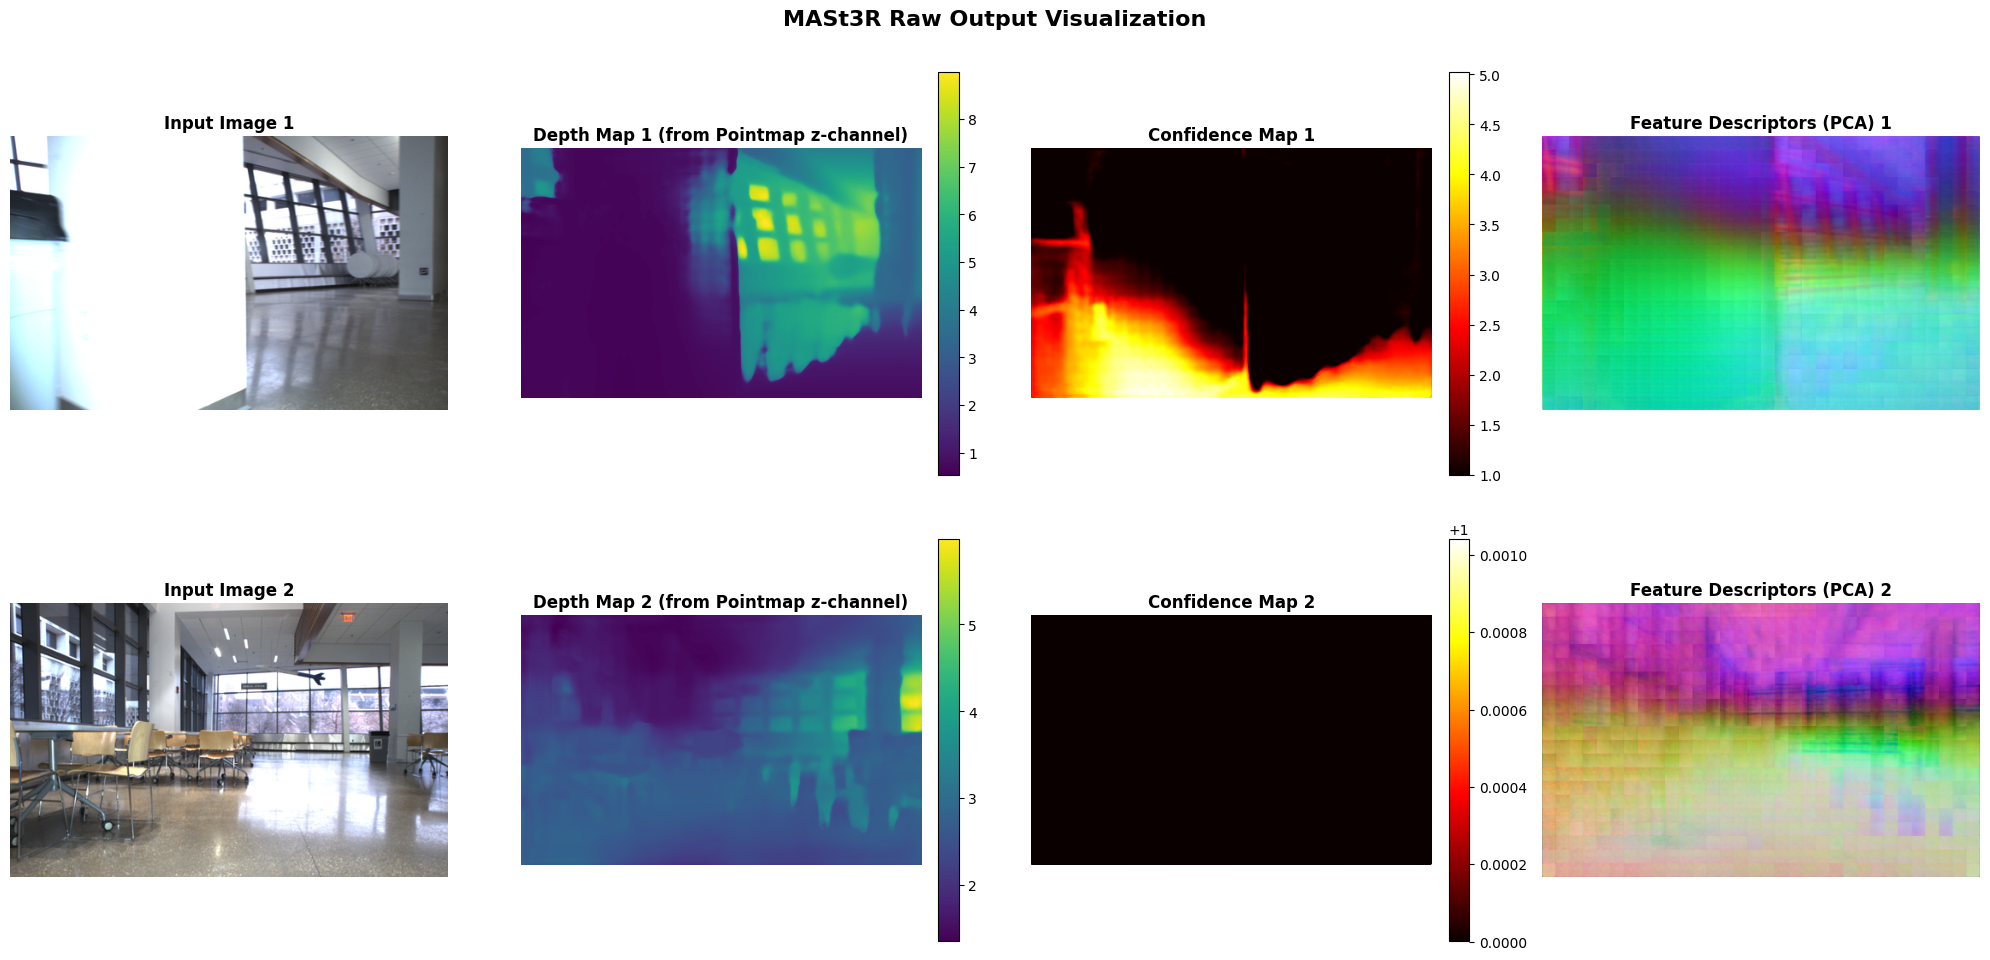

✓ Visualization complete


In [ ]:
# Create 2x4 subplot grid
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('MASt3R Raw Output Visualization', fontsize=16, fontweight='bold')

# Row 1: Image 1 outputs
# Input Image 1
axes[0, 0].imshow(img1_rgb)
axes[0, 0].set_title('Input Image 1', fontsize=12, fontweight='bold')
axes[0, 0].axis('off')

# Depth Map 1
im1 = axes[0, 1].imshow(depth1, cmap='viridis')
axes[0, 1].set_title('Depth Map 1 (from Pointmap z-channel)', fontsize=12, fontweight='bold')
axes[0, 1].axis('off')
plt.colorbar(im1, ax=axes[0, 1], fraction=0.046, pad=0.04)

# Confidence Map 1
im2 = axes[0, 2].imshow(conf1, cmap='hot')
axes[0, 2].set_title('Confidence Map 1', fontsize=12, fontweight='bold')
axes[0, 2].axis('off')
plt.colorbar(im2, ax=axes[0, 2], fraction=0.046, pad=0.04)

# Feature Descriptors (PCA) 1
axes[0, 3].imshow(desc1_rgb)
axes[0, 3].set_title('Feature Descriptors (PCA) 1', fontsize=12, fontweight='bold')
axes[0, 3].axis('off')

# Row 2: Image 2 outputs
# Input Image 2
axes[1, 0].imshow(img2_rgb)
axes[1, 0].set_title('Input Image 2', fontsize=12, fontweight='bold')
axes[1, 0].axis('off')

# Depth Map 2
im3 = axes[1, 1].imshow(depth2, cmap='viridis')
axes[1, 1].set_title('Depth Map 2 (from Pointmap z-channel)', fontsize=12, fontweight='bold')
axes[1, 1].axis('off')
plt.colorbar(im3, ax=axes[1, 1], fraction=0.046, pad=0.04)

# Confidence Map 2
im4 = axes[1, 2].imshow(conf2, cmap='hot')
axes[1, 2].set_title('Confidence Map 2', fontsize=12, fontweight='bold')
axes[1, 2].axis('off')
plt.colorbar(im4, ax=axes[1, 2], fraction=0.046, pad=0.04)

# Feature Descriptors (PCA) 2
axes[1, 3].imshow(desc2_rgb)
axes[1, 3].set_title('Feature Descriptors (PCA) 2', fontsize=12, fontweight='bold')
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

print("✓ Visualization complete")


## 9. Fast Reciprocal Matching and Correspondence Visualization

Perform fast reciprocal nearest neighbor matching using both geometric (pointmaps) and feature-based (descriptors) matching, then visualize the correspondences.


In [ ]:
from mast3r.fast_nn import fast_reciprocal_NNs, extract_correspondences_nonsym

# Convert descriptors to torch tensors if needed
desc1_torch = torch.from_numpy(desc1).to(device)
desc2_torch = torch.from_numpy(desc2).to(device)

# Convert confidence maps to numpy (function expects numpy arrays for confidence)
# They will be converted to tensors inside the function if needed
conf1_np = conf1 if isinstance(conf1, np.ndarray) else conf1.cpu().numpy()
conf2_np = conf2 if isinstance(conf2, np.ndarray) else conf2.cpu().numpy()

# Convert pointmaps to torch tensors
pts3d_1_torch = torch.from_numpy(pts3d_1).to(device)
pts3d_2_torch = torch.from_numpy(pts3d_2).to(device)

print("Performing fast reciprocal matching...")
print("=" * 60)

# 1. Feature-based matching using descriptors
print("\n1. Feature-based matching (using descriptors)...")
# Use dot product similarity for descriptor matching
feat_corres = extract_correspondences_nonsym(
    desc1_torch, desc2_torch, 
    conf1_np, conf2_np,  # Pass numpy arrays for confidence
    subsample=8,  # Subsample for faster matching
    device=device,
    ptmap_key='pred_desc',  # Use descriptors
    pixel_tol=0
)

# Convert to numpy
feat_xy1, feat_xy2, feat_conf = to_numpy(feat_corres)
print(f"   Found {len(feat_xy1)} feature-based correspondences")

# 2. Geometric matching using pointmaps
print("\n2. Geometric matching (using pointmaps)...")
# Use L2 distance for 3D point matching
geom_xy1, geom_xy2 = fast_reciprocal_NNs(
    pts3d_1_torch, pts3d_2_torch,
    subsample_or_initxy1=8,  # Subsample for faster matching
    ret_xy=True,
    pixel_tol=0,
    device=device,
    dist='l2'  # L2 distance for 3D points
)
print(f"   Found {len(geom_xy1)} geometric correspondences")

print("\n✓ Matching complete")


Performing fast reciprocal matching...

1. Feature-based matching (using descriptors)...
   Found 355 feature-based correspondences

2. Geometric matching (using pointmaps)...
   Found 30 geometric correspondences

✓ Matching complete



Visualizing feature-based correspondences...


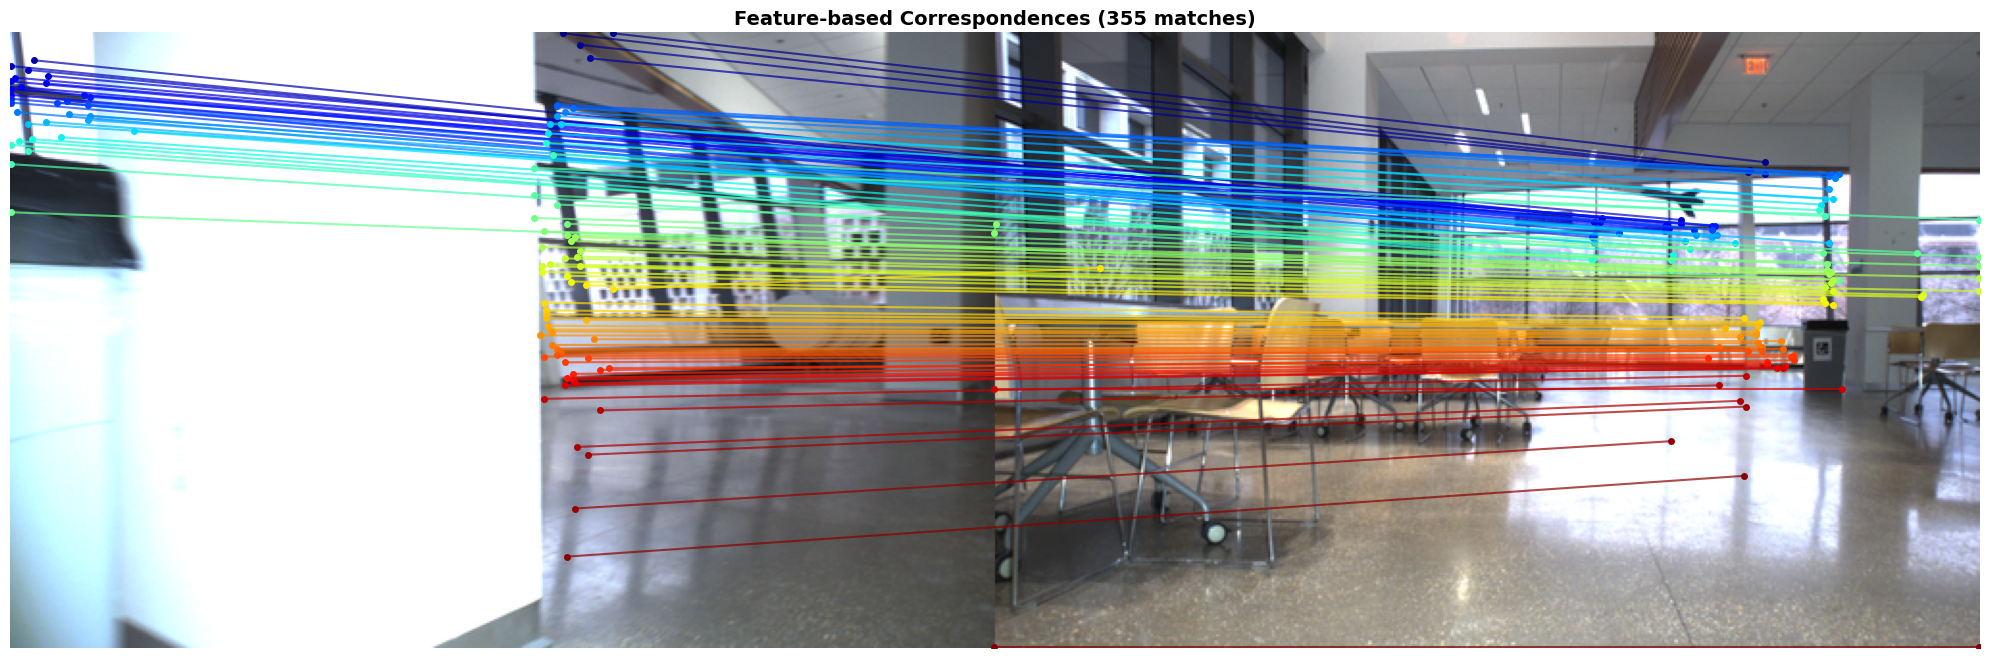


Visualizing geometric correspondences...


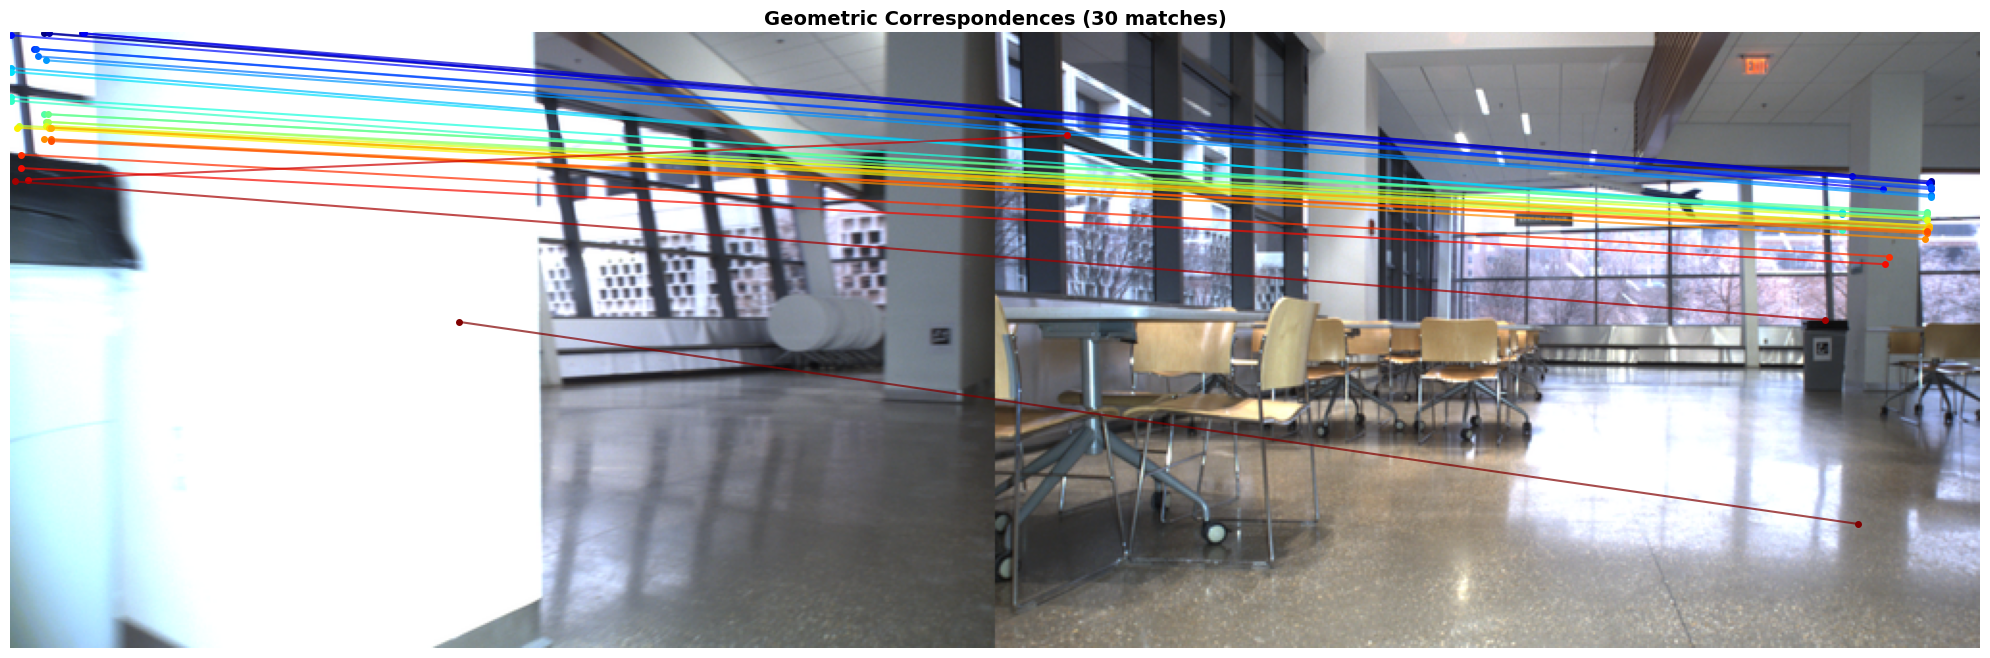

In [ ]:
# Visualize correspondences
def visualize_correspondences(img1, img2, xy1, xy2, title, n_viz=100):
    """Visualize correspondences between two images"""
    # Convert images to numpy if needed
    if isinstance(img1, torch.Tensor):
        img1 = to_numpy(img1)
    if isinstance(img2, torch.Tensor):
        img2 = to_numpy(img2)
    
    # Ensure images are in [0, 255] range for display
    if img1.max() <= 1.0:
        img1_viz = (img1 * 255).astype(np.uint8)
    else:
        img1_viz = img1.astype(np.uint8)
    if img2.max() <= 1.0:
        img2_viz = (img2 * 255).astype(np.uint8)
    else:
        img2_viz = img2.astype(np.uint8)
    
    H0, W0 = img1_viz.shape[:2]
    H1, W1 = img2_viz.shape[:2]
    
    # Pad images to same height
    img0_pad = np.pad(img1_viz, ((0, max(H1 - H0, 0)), (0, 0), (0, 0)), 
                      'constant', constant_values=0)
    img1_pad = np.pad(img2_viz, ((0, max(H0 - H1, 0)), (0, 0), (0, 0)), 
                      'constant', constant_values=0)
    
    # Concatenate horizontally
    img_concat = np.concatenate((img0_pad, img1_pad), axis=1)
    
    # Select matches to visualize
    num_matches = len(xy1)
    n_viz = min(n_viz, num_matches)
    match_idx_to_viz = np.round(np.linspace(0, num_matches - 1, n_viz)).astype(int)
    viz_xy1 = xy1[match_idx_to_viz]
    viz_xy2 = xy2[match_idx_to_viz]
    
    # Create figure
    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.imshow(img_concat)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.axis('off')
    
    # Draw correspondences
    cmap = plt.get_cmap('jet')
    for i in range(n_viz):
        x0, y0 = viz_xy1[i]
        x1, y1 = viz_xy2[i]
        color = cmap(i / (n_viz - 1))
        ax.plot([x0, x1 + W0], [y0, y1], '-', 
                color=color, linewidth=1.5, alpha=0.7)
        ax.plot(x0, y0, 'o', color=color, markersize=4)
        ax.plot(x1 + W0, y1, 'o', color=color, markersize=4)
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Visualize feature-based correspondences
print("\nVisualizing feature-based correspondences...")
fig1 = visualize_correspondences(
    img1_rgb, img2_rgb, 
    feat_xy1, feat_xy2,
    f'Feature-based Correspondences ({len(feat_xy1)} matches)',
    n_viz=100
)

# Visualize geometric correspondences
print("\nVisualizing geometric correspondences...")
fig2 = visualize_correspondences(
    img1_rgb, img2_rgb,
    geom_xy1, geom_xy2,
    f'Geometric Correspondences ({len(geom_xy1)} matches)',
    n_viz=100
)


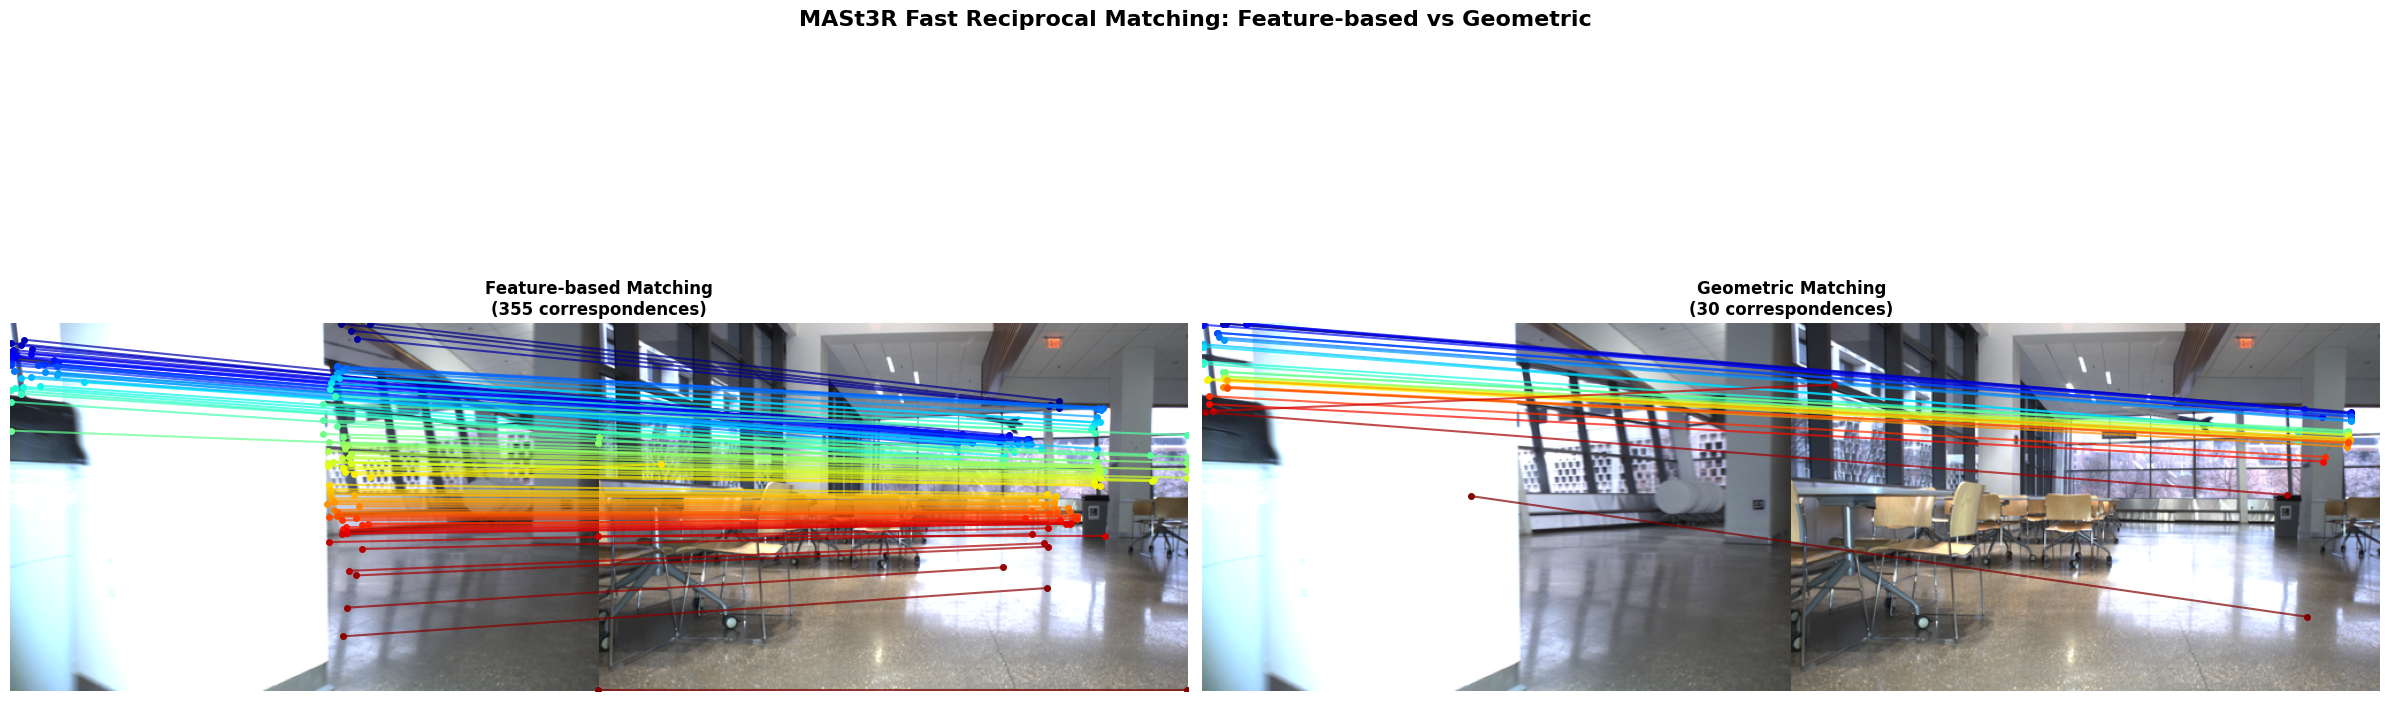


✓ Correspondence visualization complete
  Feature-based matches: 355
  Geometric matches: 30


In [ ]:
# Side-by-side comparison of both matching methods
fig, axes = plt.subplots(1, 2, figsize=(24, 10))
fig.suptitle('MASt3R Fast Reciprocal Matching: Feature-based vs Geometric', 
             fontsize=16, fontweight='bold')

# Prepare images for visualization
H0, W0 = img1_rgb.shape[:2]
H1, W1 = img2_rgb.shape[:2]
max_H = max(H0, H1)

# Convert to uint8 if needed
img1_viz = (img1_rgb * 255).astype(np.uint8) if img1_rgb.max() <= 1.0 else img1_rgb.astype(np.uint8)
img2_viz = (img2_rgb * 255).astype(np.uint8) if img2_rgb.max() <= 1.0 else img2_rgb.astype(np.uint8)

# Pad images
img0_pad = np.pad(img1_viz, ((0, max_H - H0), (0, 0), (0, 0)), 'constant', constant_values=0)
img1_pad = np.pad(img2_viz, ((0, max_H - H1), (0, 0), (0, 0)), 'constant', constant_values=0)
img_concat = np.concatenate((img0_pad, img1_pad), axis=1)

# Feature-based matching visualization
axes[0].imshow(img_concat)
axes[0].set_title(f'Feature-based Matching\n({len(feat_xy1)} correspondences)', 
                  fontsize=12, fontweight='bold')
axes[0].axis('off')

n_viz = min(100, len(feat_xy1))
match_idx = np.round(np.linspace(0, len(feat_xy1) - 1, n_viz)).astype(int)
cmap = plt.get_cmap('jet')
for i, idx in enumerate(match_idx):
    x0, y0 = feat_xy1[idx]
    x1, y1 = feat_xy2[idx]
    color = cmap(i / (n_viz - 1))
    axes[0].plot([x0, x1 + W0], [y0, y1], '-', color=color, linewidth=1.5, alpha=0.7)
    axes[0].plot(x0, y0, 'o', color=color, markersize=4)
    axes[0].plot(x1 + W0, y1, 'o', color=color, markersize=4)

# Geometric matching visualization
axes[1].imshow(img_concat)
axes[1].set_title(f'Geometric Matching\n({len(geom_xy1)} correspondences)', 
                  fontsize=12, fontweight='bold')
axes[1].axis('off')

n_viz = min(100, len(geom_xy1))
match_idx = np.round(np.linspace(0, len(geom_xy1) - 1, n_viz)).astype(int)
for i, idx in enumerate(match_idx):
    x0, y0 = geom_xy1[idx]
    x1, y1 = geom_xy2[idx]
    color = cmap(i / (n_viz - 1))
    axes[1].plot([x0, x1 + W0], [y0, y1], '-', color=color, linewidth=1.5, alpha=0.7)
    axes[1].plot(x0, y0, 'o', color=color, markersize=4)
    axes[1].plot(x1 + W0, y1, 'o', color=color, markersize=4)

plt.tight_layout()
plt.show()

print(f"\n✓ Correspondence visualization complete")
print(f"  Feature-based matches: {len(feat_xy1)}")
print(f"  Geometric matches: {len(geom_xy1)}")


## 10. Export Raw Data

Save all raw tensors as `.npy` files for further numerical analysis.


In [ ]:
# Create output directory
output_dir = "mast3r_raw_outputs"
os.makedirs(output_dir, exist_ok=True)

# Save all raw data
print(f"Saving raw data to '{output_dir}/' directory...")

# Input images
np.save(f"{output_dir}/image1_rgb.npy", img1_rgb)
np.save(f"{output_dir}/image2_rgb.npy", img2_rgb)

# Pointmaps (full 3D coordinates)
np.save(f"{output_dir}/pointmap1.npy", pts3d_1)
np.save(f"{output_dir}/pointmap2.npy", pts3d_2)

# Depth maps
np.save(f"{output_dir}/depth1.npy", depth1)
np.save(f"{output_dir}/depth2.npy", depth2)

# Confidence maps
np.save(f"{output_dir}/confidence1.npy", conf1)
np.save(f"{output_dir}/confidence2.npy", conf2)

# Descriptors (full high-dimensional)
np.save(f"{output_dir}/descriptors1.npy", desc1)
np.save(f"{output_dir}/descriptors2.npy", desc2)

# PCA-reduced descriptors
np.save(f"{output_dir}/descriptors1_pca.npy", desc1_pca.reshape(H, W, 3))
np.save(f"{output_dir}/descriptors2_pca.npy", desc2_pca.reshape(H, W, 3))

# Save PCA model info
np.save(f"{output_dir}/pca_components.npy", pca.components_)
np.save(f"{output_dir}/pca_mean.npy", pca.mean_)
np.save(f"{output_dir}/pca_explained_variance_ratio.npy", pca.explained_variance_ratio_)

print(f"✓ All data saved to '{output_dir}/'")
print("\nSaved files:")
for file in sorted(os.listdir(output_dir)):
    filepath = os.path.join(output_dir, file)
    size_mb = os.path.getsize(filepath) / (1024 * 1024)
    print(f"  - {file} ({size_mb:.2f} MB)")


Saving raw data to 'mast3r_raw_outputs/' directory...
✓ All data saved to 'mast3r_raw_outputs/'

Saved files:
  - confidence1.npy (0.63 MB)
  - confidence2.npy (0.63 MB)
  - depth1.npy (0.63 MB)
  - depth2.npy (0.63 MB)
  - descriptors1.npy (15.00 MB)
  - descriptors1_pca.npy (1.88 MB)
  - descriptors2.npy (15.00 MB)
  - descriptors2_pca.npy (1.88 MB)
  - image1_rgb.npy (1.88 MB)
  - image2_rgb.npy (1.88 MB)
  - pca_components.npy (0.00 MB)
  - pca_explained_variance_ratio.npy (0.00 MB)
  - pca_mean.npy (0.00 MB)
  - pointmap1.npy (1.88 MB)
  - pointmap2.npy (1.88 MB)


## 11. Summary

This notebook has demonstrated:

1. **Environment Setup**: Installation and import of MASt3R
2. **Model Loading**: Loading the MASt3R_ViTLarge_BaseDecoder_512_catmlpdpt_metric checkpoint
3. **Image Processing**: Loading and resizing two images to 512px
4. **Inference**: Running MASt3R to extract predictions
5. **Data Extraction**: Extracting pointmaps, depth maps, confidence maps, and descriptors
6. **PCA Visualization**: Reducing high-dimensional descriptors to 3 RGB components
7. **Visualization**: Creating a 2x4 grid showing all outputs
8. **Fast Reciprocal Matching**: Performing feature-based and geometric matching between images
9. **Correspondence Visualization**: Visualizing matches with lines connecting corresponding points
10. **Data Export**: Saving all raw tensors as `.npy` files

### Key Outputs:
- **Pointmaps**: 3D coordinates (H, W, 3) - the z-channel represents depth
- **Confidence Maps**: Network's certainty for each pixel
- **Descriptors**: High-dimensional feature vectors for matching
- **PCA Descriptors**: 3-component RGB visualization of descriptors

All raw data has been saved to the `mast3r_raw_outputs/` directory for further analysis.
